In [29]:
import pandas as pd
import data_utility
import requests
import sys
import nltk
import string
import matplotlib.pyplot as plt
import os

nltk.download('stopwords')

from geopy.geocoders import Nominatim
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from dotenv import load_dotenv
from datetime import datetime

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arnab\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
# Load environment variables.
load_dotenv()

OPENTRIPMAP_API_KEY = os.getenv("OPENTRIPMAP_API_KEY")
OPENWEATHERMAP_API_KEY= os.getenv("OPENWEATHERMAP_API_KEY")

97fb12723ffe2b2de24195a125f4d7e4


In [8]:
hotel_reviews_df = data_utility.get_hotel_reviews()
hotel_reviews_df.head(3)

# count number of records in dataframe
print("Number of records in dataframe: ", len(hotel_reviews_df))

Number of records in dataframe:  19787


c:\Arnab\Work_Technical\Technical\AI_ML\OSU_Bootcamp\Assignment_Submission\project3-group3-travel-assistant\src\data_utility.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  hotel_reviews_df = pd.concat(h_dfs).reset_index(drop=True)


In [12]:
# Function to get list of hotels in a city that match the review keywords
def get_hotels_by_review_and_city(hotel_reviews_df, city_name, review_keywords):

    # Create a copy of the dataframe hotel_reviews_df
    hotel_review_keyw_match_df = hotel_reviews_df.copy()

    # Preprocess reviews text
    hotel_review_keyw_match_df['reviews.text'] = hotel_review_keyw_match_df['reviews.text'].apply(lambda x: str(x).lower())

    # Filter hotels by city city_hotels_df
    city_review_keyw_match_hotels_df = hotel_review_keyw_match_df[hotel_review_keyw_match_df['city'].str.lower() == city_name.lower()]

    # Initialize TF-IDF vectorizer
    vectorizer = TfidfVectorizer()

    # Fit TF-IDF vectorizer
    review_vectors = vectorizer.fit_transform(city_review_keyw_match_hotels_df['reviews.text'])

    # Transform review keyword to match vectorizer
    review_keyword_vector = vectorizer.transform([review_keywords.lower()])

    # Calculate cosine similarity between review keyword and all reviews
    similarity_scores = cosine_similarity(review_vectors, review_keyword_vector)

    # Get indices of hotels with high similarity
    similar_hotel_indices = similarity_scores.flatten().argsort()[::-1]

    # Extract hotel names with highest similarity scores
    similar_hotels = city_review_keyw_match_hotels_df.iloc[similar_hotel_indices][:50]  # Adjust to get more or less hotels

    # Get unique hotel names
    unique_hotels = similar_hotels['name'].drop_duplicates().tolist()

    return unique_hotels


# Function to filter hotels by city
def filter_hotels_by_city(city_name):
    return hotel_reviews_df[hotel_reviews_df['city'].str.lower() == city_name.lower()]

# Function to recommend top hotels
def m_top_n_hotels_by_city(city_name, top_n_hotels_by_city):
    city_hotels = filter_hotels_by_city(city_name)
    top_hotels = city_hotels.groupby('name')['reviews.rating'].mean().sort_values(ascending=False).head( int(top_n_hotels_by_city) )
    return top_hotels

def get_lat_long(city_name):
    base_url = "https://nominatim.openstreetmap.org/search"
    params = {
        "q": city_name,
        "format": "json"
    }
    response = requests.get(base_url, params=params)
    data = response.json()
    if data:
        lat = data[0]["lat"]
        lon = data[0]["lon"]
        return lat, lon
    else:
        return None, None

def get_top_attractions(longitude, latitude, n, api_key):
    try:
        # Convert n to an integer
        n = int(n)
        if n <= 0:
            raise ValueError("N must be a positive integer")

        # Make API call
        url = f"https://api.opentripmap.com/0.1/en/places/radius?radius=100000&lon={longitude}&lat={latitude}&kinds=tourist_object&format=json&limit={n}&apikey={api_key}"
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for bad response status

        # Extract top attractions
        attractions = response.json()

        # Extract names of top attractions
        top_attractions = [attraction['name'] for attraction in attractions]
        return top_attractions
    
    except ValueError as ve:
        print(f"Error: {ve}")
    except requests.RequestException as re:
        print(f"Error making API request: {re}")
    except KeyError:
        print("Error: Response format unexpected, please check API documentation.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Example usage
city_name = input("Enter the city name for which you are plannng the trip: ")
top_n_hotels_by_city = input(f"Enter the number of top hotels to display in {city_name}: ")
review_keywords = input(f"Enter Hotel review keyword to get recommendation in {city_name}: ")
top_n_attraction = input("Enter the number of tourist attractions in {city_name} to recommend: ")

top_hotels = m_top_n_hotels_by_city(city_name, top_n_hotels_by_city)

# Get hotels by review keyword and city
matching_hotels = get_hotels_by_review_and_city(hotel_reviews_df, city_name, review_keywords)

lat, lon = get_lat_long(city_name)

if lat and lon:
    # print("\n")
    # print(f"----------------------------------------------------------")
    # print(f"The latitude and longitude of {city_name} are: {lat}, {lon}")
    # print(f"----------------------------------------------------------")

    attractions = get_top_attractions(lon, lat, top_n_attraction, OPENTRIPMAP_API_KEY)
    if attractions:
        print("\n")
        print(f"-------------------------------------")
        print(f"Top {top_n_attraction} attractions of {city_name} are:")
        print(f"-------------------------------------")
        for i, attraction in enumerate(attractions, 1):
            print(f"{i}. {attraction}")
else:
    print("\n")
    print(f"-------------------------------------")
    print(f"Couldn't find latitude and longitude for {city_name}")
    print(f"-------------------------------------")

print("\n")
print(f"-------------------------------------")
print(f"Top {top_n_hotels_by_city} Hotels in {city_name} are: ")
print(f"-------------------------------------")
print(top_hotels)

# Print next line
print("\n")
print(f"------------------------------------------------------------------------------------------------------------")
print(f"Hotels matching input user review keywords '{review_keywords.lower()}' in '{city_name.lower()}' : {matching_hotels}")
print(f"------------------------------------------------------------------------------------------------------------")



----------------------------------------------------------
The latitude and longitude of Chicago are: 41.8755616, -87.6244212
----------------------------------------------------------


-------------------------------------
Top 3 attractions of Chicago are:
-------------------------------------
1. Paris Metro Entryway (Metra)
2. Chicago "L"
3. Begin Route 66


-------------------------------------
Top 3 Hotels in Chicago are: 
-------------------------------------
name
Hampton Inn Chicago North-loyola Station    5.000000
Virgin Hotels Chicago                       4.776316
Conrad Chicago                              4.770270
Name: reviews.rating, dtype: float64


------------------------------------------------------------------------------------------------------------
Hotels matching input user review keywords 'breakfast' in 'chicago' : ['Kinzie Hotel', 'Clarion Inn & Suites', 'Hyatt Place Chicago Downtown/The Loop', 'dana hotel and spa', 'Comfort Suites Michigan Avenue - Loop', '

------------------------------------------------------------------------------------------------------------
Top 10 review words with their counts for hotel 'hyatt place chicago downtown/the loop' in city 'chicago' :
------------------------------------------------------------------------------------------------------------
great: 46
room: 44
staff: 43
experience: 38
breakfast: 35
Chicago: 33
location: 32
Thanks: 31
review: 31
us: 23


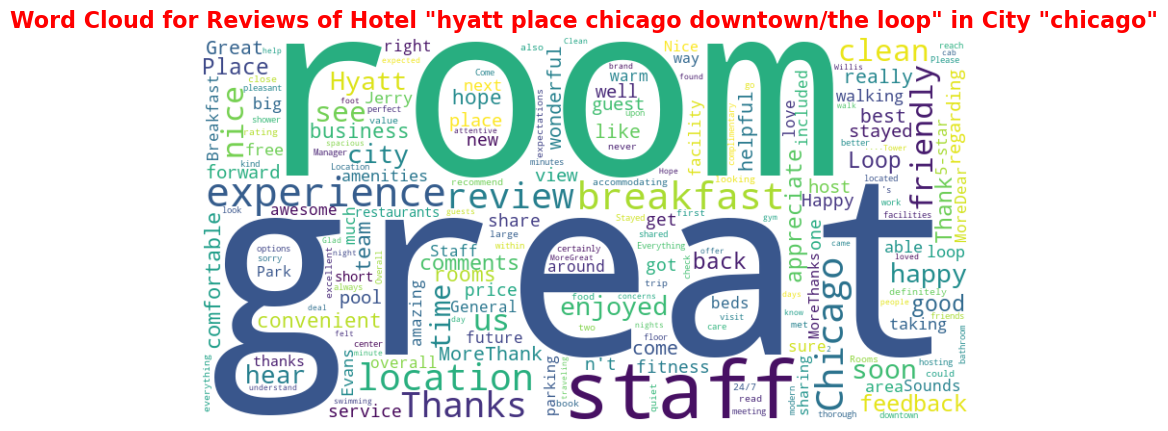

In [5]:
# Function to get word counts for reviews for a specific city and hotel
# Create the word cloud for the review words

def get_review_word_count_city_hotel(hotel_reviews_df, city_name, hotel_name):
    # Filter reviews for the specified city and hotel
    hotel_reviews = hotel_reviews_df[(hotel_reviews_df['city'].str.lower() == city_name.lower()) & (hotel_reviews_df['name'].str.lower() == hotel_name.lower())]['reviews.text']

    # Initialize an empty list to store all tokens from reviews
    all_tokens = []

    # Tokenize each review and add tokens to the list
    for review in hotel_reviews:
        tokens = word_tokenize(review)
        all_tokens.extend(tokens)

    # Remove stopwords and punctuation
    stop_words = set(stopwords.words('english'))
    punctuation = set(string.punctuation)

     # List of words to be excluded
    exclusion_list = ['hotel', 'stay', 'would', '...']  # Add the exception words here

    filtered_tokens = [word for word in all_tokens 
                       if word.lower() not in stop_words 
                       and 
                       word not in punctuation
                       and
                       word.lower() not in exclusion_list
                       ]

    # Count word frequencies
    word_counts = Counter(filtered_tokens)

    # Sort word counts in descending order
    sorted_word_counts = dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True))

    return sorted_word_counts

# Example usage:
# city_name = input("Enter the city name: ")
hotel_name = input("Enter the hotel name: ")
top_n_review_words = input(f"Enter the number of top reviewed words to display of {hotel_name} in {city_name}: ")

# Get word counts for the specified city and hotel
word_counts = get_review_word_count_city_hotel(hotel_reviews_df, city_name, hotel_name)

# Get top N words with their counts
word_counts_top_n = dict(list(word_counts.items())[:int(top_n_review_words)])

print(f"------------------------------------------------------------------------------------------------------------")
print(f"Top {top_n_review_words} review words with their counts for hotel '{hotel_name.lower()}' in city '{city_name.lower()}' :")
print(f"------------------------------------------------------------------------------------------------------------")
for word, count in word_counts_top_n.items():
    print("%s: %d" % (word, count))

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

# Plot the WordCloud
# I want the chart title to be in red color and be underlined
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Reviews of Hotel "%s" in "%s"' % (hotel_name.lower(), city_name.lower()), color='red', fontsize=16, fontweight='bold')
plt.show()